# General

This version is applying everything to train dataset first, and then applies everything to test dataset later on.

# Step 0: Importing Packages

In [1]:
#we import all at the beginning so it's easier to see which packages are used by this notebook

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns 
import datetime as dt

#import auxiliar functions
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(os.path.dirname(currentdir))
sys.path.insert(1, parentdir)
from utils.helper_functions import *

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import category_encoders as ce
import joblib

#sklearn functions
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imbPipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn import preprocessing
from imblearn.over_sampling import SMOTENC, SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import sklearn.feature_selection as fs
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_predict as cvp
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score as cvs
from sklearn.metrics import confusion_matrix

# Step 1: Reading Data and Some Exploration

In [2]:
main_path = "C:/Users/sssalas/OneDrive - Philippine Competition Commission/Desktop/ML in-class/1/cml2-probability-of-death-with-k-nn/"

# reading the main data
df = pd.read_csv(main_path + "mimic_train.csv")
df_orig = df.copy()

df_test = pd.read_csv(main_path+ "mimic_test_death.csv")
df_test_orig = df_test.copy()

#reading the comorbidity dataset
comorbidity = pd.read_csv(main_path + "extra_data/MIMIC_diagnoses.csv")
comorbidity_orig = comorbidity.copy()

In [3]:
df.head()

,HOSPITAL_EXPIRE_FLAG,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,...,Diff,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,ICD9_diagnosis,FIRST_CAREUNIT,LOS
0,0,55440,195768,228357,89.0,145.0,121.043478,74.0,127.0,106.586957,...,-61961.78470,EMERGENCY,Medicare,PROTESTANT QUAKER,SINGLE,WHITE,GASTROINTESTINAL BLEED,5789,MICU,4.5761
1,0,76908,126136,221004,63.0,110.0,79.117647,89.0,121.0,106.733333,...,-43146.18378,EMERGENCY,Private,UNOBTAINABLE,MARRIED,WHITE,ESOPHAGEAL FOOD IMPACTION,53013,MICU,0.7582
2,0,95798,136645,296315,81.0,98.0,91.689655,88.0,138.0,112.785714,...,-42009.96157,EMERGENCY,Medicare,PROTESTANT QUAKER,SEPARATED,BLACK/AFRICAN AMERICAN,UPPER GI BLEED,56983,MICU,3.7626
3,0,40708,102505,245557,76.0,128.0,98.857143,84.0,135.0,106.972973,...,-43585.37922,ELECTIVE,Medicare,NOT SPECIFIED,WIDOWED,WHITE,HIATAL HERNIA/SDA,5533,SICU,3.8734
4,0,28424,127337,225281,NaN,NaN,NaN,NaN,NaN,NaN,...,-50271.76602,EMERGENCY,Medicare,JEWISH,WIDOWED,WHITE,ABDOMINAL PAIN,56211,TSICU,5.8654


In [4]:
df.columns

Index(['HOSPITAL_EXPIRE_FLAG', 'subject_id', 'hadm_id', 'icustay_id',
       'HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min',
       'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean',
       'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min',
       'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean',
       'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max',
       'Glucose_Mean', 'GENDER', 'DOB', 'DOD', 'ADMITTIME', 'DISCHTIME',
       'DEATHTIME', 'Diff', 'ADMISSION_TYPE', 'INSURANCE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY', 'DIAGNOSIS', 'ICD9_diagnosis',
       'FIRST_CAREUNIT', 'LOS'],
      dtype='object')

In [5]:
df.describe()

,HOSPITAL_EXPIRE_FLAG,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,...,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,Diff,LOS
count,20885.000000,20885.000000,20885.000000,20885.000000,18698.000000,18698.000000,18698.000000,18677.000000,18677.000000,18677.000000,...,18388.000000,18388.000000,18682.000000,18682.000000,18682.000000,20632.000000,20632.000000,20632.000000,20885.000000,20885.000000
mean,0.112282,58950.496098,150082.402298,250202.495523,69.705904,105.239801,85.180250,91.110564,150.725920,119.145423,...,37.428781,36.751717,91.007494,99.555883,96.866685,106.781975,182.129604,138.856428,-51617.069830,3.701046
std,0.315720,25299.439535,28898.479845,28909.806302,14.869840,20.922613,15.318208,17.532534,23.833793,16.701503,...,0.799897,0.603476,7.399390,1.159792,2.333108,35.178811,92.665603,44.933145,10686.395846,5.175721
min,0.000000,23.000000,100001.000000,200001.000000,2.000000,39.000000,34.714286,5.000000,46.000000,46.000000,...,30.800000,30.666667,1.000000,57.000000,47.666667,2.000000,42.000000,42.000000,-72740.274440,0.056600
25%,0.000000,41132.000000,125157.000000,225153.000000,60.000000,90.000000,74.272727,81.000000,134.000000,107.100000,...,36.944444,36.388889,90.000000,100.000000,95.812500,86.000000,126.000000,110.750000,-60864.454110,1.165400
50%,0.000000,60441.000000,150152.000000,250452.000000,69.000000,103.000000,84.131183,90.000000,148.000000,116.901961,...,37.333333,36.731481,92.000000,100.000000,97.142857,102.000000,161.000000,128.666667,-51561.703460,2.020800
75%,0.000000,80286.000000,175017.000000,275303.000000,79.000000,118.000000,95.185588,101.000000,164.000000,129.465116,...,37.888889,37.092593,94.000000,100.000000,98.346154,121.000000,206.000000,154.578571,-42327.560030,3.915800
max,1.000000,99999.000000,199999.000000,299998.000000,141.000000,280.000000,163.875000,181.000000,323.000000,202.172414,...,42.000000,40.238333,100.000000,100.000000,100.000000,563.000000,2440.000000,771.900000,-32157.494580,101.739000


In [6]:
df.dtypes

HOSPITAL_EXPIRE_FLAG      int64
subject_id                int64
hadm_id                   int64
icustay_id                int64
HeartRate_Min           float64
HeartRate_Max           float64
HeartRate_Mean          float64
SysBP_Min               float64
SysBP_Max               float64
SysBP_Mean              float64
DiasBP_Min              float64
DiasBP_Max              float64
DiasBP_Mean             float64
MeanBP_Min              float64
MeanBP_Max              float64
MeanBP_Mean             float64
RespRate_Min            float64
RespRate_Max            float64
RespRate_Mean           float64
TempC_Min               float64
TempC_Max               float64
TempC_Mean              float64
SpO2_Min                float64
SpO2_Max                float64
SpO2_Mean               float64
Glucose_Min             float64
Glucose_Max             float64
Glucose_Mean            float64
GENDER                   object
DOB                      object
DOD                      object
ADMITTIM

In [7]:
df.shape

(20885, 44)

In [8]:
df.isnull().sum()

HOSPITAL_EXPIRE_FLAG        0
subject_id                  0
hadm_id                     0
icustay_id                  0
HeartRate_Min            2187
HeartRate_Max            2187
HeartRate_Mean           2187
SysBP_Min                2208
SysBP_Max                2208
SysBP_Mean               2208
DiasBP_Min               2209
DiasBP_Max               2209
DiasBP_Mean              2209
MeanBP_Min               2186
MeanBP_Max               2186
MeanBP_Mean              2186
RespRate_Min             2189
RespRate_Max             2189
RespRate_Mean            2189
TempC_Min                2497
TempC_Max                2497
TempC_Mean               2497
SpO2_Min                 2203
SpO2_Max                 2203
SpO2_Mean                2203
Glucose_Min               253
Glucose_Max               253
Glucose_Mean              253
GENDER                      0
DOB                         0
DOD                     13511
ADMITTIME                   0
DISCHTIME                   0
DEATHTIME 

In [9]:
df_test.head()

#df_train has 5 columns more than the df_test

,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,...,ADMITTIME,Diff,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,ICD9_diagnosis,FIRST_CAREUNIT
0,64058,146725,208169,58.0,90.0,85.244898,77.0,153.0,98.490909,40.0,...,2196-02-23 11:45:00,-67454.42740,ELECTIVE,Medicare,CATHOLIC,MARRIED,WHITE,AORTIC STENOSIS\CORONARY ARTERY BYPASS GRAFT W...,4241,CSRU
1,55871,108789,251754,91.0,145.0,115.055556,73.0,143.0,101.210526,42.0,...,2103-10-22 23:58:00,-34204.08546,EMERGENCY,Private,NOT SPECIFIED,MARRIED,WHITE,HYPERGLYCEMIA,25013,MICU
2,42892,139885,242171,106.0,132.0,117.750000,93.0,137.0,116.222222,51.0,...,2115-06-28 07:15:00,-38710.61714,ELECTIVE,Medicare,CATHOLIC,MARRIED,WHITE,KIDNEY STONES/SDA,5920,MICU
3,66629,173017,263035,72.0,105.0,83.627119,72.0,168.0,126.981818,39.0,...,2162-08-01 21:00:00,-54902.54313,EMERGENCY,Private,EPISCOPALIAN,WIDOWED,WHITE,RIGHT FEMUR FRACTURE,82120,CCU
4,79851,171573,279388,85.0,124.0,98.600000,86.0,144.0,110.666667,52.0,...,2103-01-16 22:05:00,-33906.93488,EMERGENCY,Medicare,CATHOLIC,SINGLE,WHITE,PNEUMONIA;RAPID AF;HYPOXIA,51884,MICU


<AxesSubplot:>

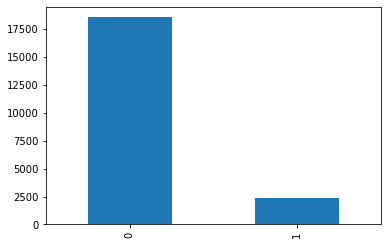

In [10]:
df.HOSPITAL_EXPIRE_FLAG.value_counts().plot(kind="bar")

In [11]:
df_small = df[['HOSPITAL_EXPIRE_FLAG', 'HeartRate_Mean','SysBP_Mean', 'DiasBP_Mean', 'MeanBP_Mean', 'RespRate_Mean', 'TempC_Mean', 'SpO2_Mean', 'Glucose_Mean']]

0         AxesSubplot(0.1,0.15;0.363636x0.75)
1    AxesSubplot(0.536364,0.15;0.363636x0.75)
dtype: object

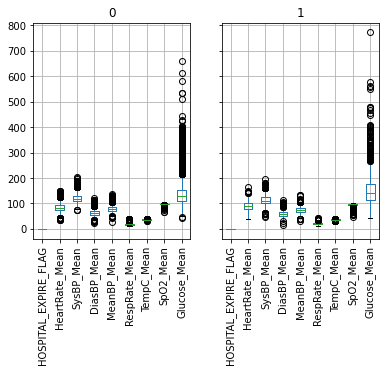

In [12]:
df_small.groupby("HOSPITAL_EXPIRE_FLAG").boxplot(rot=90)

#patients who died had higher glucose

<AxesSubplot:xlabel='HeartRate_Mean', ylabel='Density'>

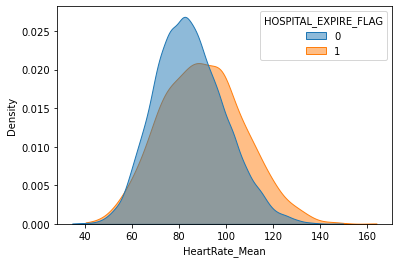

In [13]:
# Density plot of vital statistics grouped by 'HOSPITAL_EXPIRE_FLAG'
sns.kdeplot(data=df, x="HeartRate_Mean", hue="HOSPITAL_EXPIRE_FLAG", cut=0, fill=True, common_norm=False, alpha=0.5)
#those who died had higher heart rate

<AxesSubplot:xlabel='SysBP_Mean', ylabel='Density'>

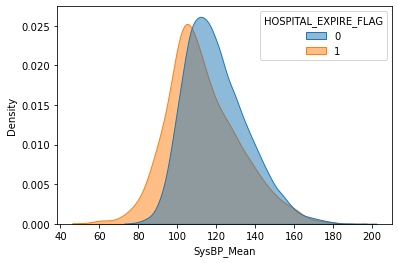

In [14]:
sns.kdeplot(data=df, x="SysBP_Mean", hue="HOSPITAL_EXPIRE_FLAG", cut=0, fill=True, common_norm=False, alpha=0.5)
#those who died had higher SysBP

<AxesSubplot:xlabel='MeanBP_Mean', ylabel='Density'>

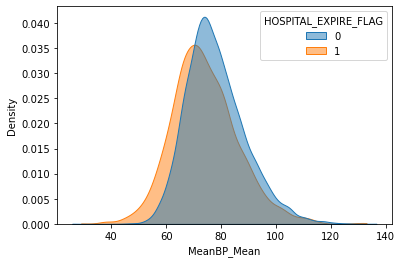

In [15]:
sns.kdeplot(data=df, x="MeanBP_Mean", hue="HOSPITAL_EXPIRE_FLAG", cut=0, fill=True, common_norm=False, alpha=0.5)
#Tho who died had lower MeanBP_Mean

<AxesSubplot:xlabel='RespRate_Mean', ylabel='Density'>

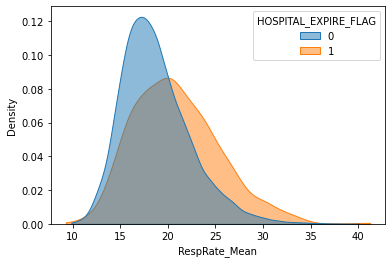

In [16]:
sns.kdeplot(data=df, x="RespRate_Mean", hue="HOSPITAL_EXPIRE_FLAG", cut=0, fill=True, common_norm=False, alpha=0.5)
#Tho who died had lower RespRate_Mean

<AxesSubplot:xlabel='TempC_Mean', ylabel='Density'>

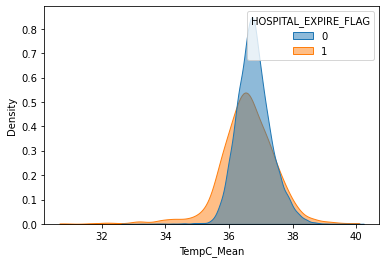

In [17]:
sns.kdeplot(data=df, x="TempC_Mean", hue="HOSPITAL_EXPIRE_FLAG", cut=0, fill=True, common_norm=False, alpha=0.5)
#those who died had lower temperature

<AxesSubplot:xlabel='SpO2_Mean', ylabel='Density'>

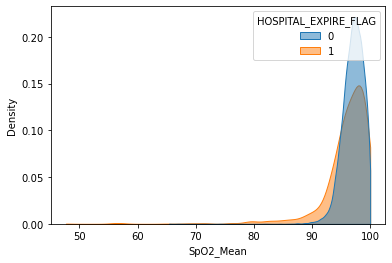

In [18]:
sns.kdeplot(data=df, x="SpO2_Mean", hue="HOSPITAL_EXPIRE_FLAG", cut=0, fill=True, common_norm=False, alpha=0.5)
#those who died had lower SpO2

<AxesSubplot:xlabel='Glucose_Mean', ylabel='Density'>

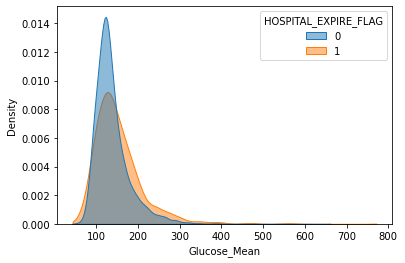

In [19]:
sns.kdeplot(data=df, x="Glucose_Mean", hue="HOSPITAL_EXPIRE_FLAG", cut=0, fill=True, common_norm=False, alpha=0.5)
#those who died had lower glucose mean but also had higer values at the extreme (vert low sugar and very high sugar are both bad)

# Step 2 Data Cleaning

First, lest check if the columns of the test and train dataset are different.

In [20]:
print(df.columns)
print(df_test.columns)

y_train = df[['HOSPITAL_EXPIRE_FLAG']]
df = df.drop(['DOD', 'DISCHTIME', 'DEATHTIME', 'LOS'], axis=1)

#same number of columns except label
print(df.shape)
print(df_test.shape)

Index(['HOSPITAL_EXPIRE_FLAG', 'subject_id', 'hadm_id', 'icustay_id',
       'HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min',
       'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean',
       'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min',
       'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean',
       'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max',
       'Glucose_Mean', 'GENDER', 'DOB', 'DOD', 'ADMITTIME', 'DISCHTIME',
       'DEATHTIME', 'Diff', 'ADMISSION_TYPE', 'INSURANCE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY', 'DIAGNOSIS', 'ICD9_diagnosis',
       'FIRST_CAREUNIT', 'LOS'],
      dtype='object')
Index(['subject_id', 'hadm_id', 'icustay_id', 'HeartRate_Min', 'HeartRate_Max',
       'HeartRate_Mean', 'SysBP_Min', 'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min',
       'DiasBP_Max', 'DiasBP_Mean', 'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean',
       'RespRate_Min', 'RespRate_Max', 'RespRate_Mean',

### Creating Age Column

We observe that there are columns that deals with time, namely DOB (date of birth) and ADMITTIME (time of admission). We could use these columns to calculate age of patient. 

We add the Diff column as the true dates have been masked to protect the identity of the patient. Then we calculate the age at time of admission as the difference between ADMITTIME and DOB. This variable is imprtant as older patients are more likely to die.

For patients over age 89, they shifted the date of birth by 300 years. We need to adjust for this accordingly. It is also important to note that we don't have a way of knowing the exact age of patients older than 89 years old.

In [21]:
for my_df in [df, df_test]:
# Convert admittime to date, adding "Diff" to make the dates realistic
    my_df['ADMITTIME'] = (pd.to_datetime(my_df['ADMITTIME']) + my_df["Diff"].apply(lambda x: dt.timedelta(x))).apply(lambda x: x.date())
# Convert dob to date, adding "Diff" to make the dates realistic
    my_df['DOB'] = (pd.to_datetime(my_df['DOB']) + my_df["Diff"].apply(lambda x: dt.timedelta(x))).apply(lambda x: x.date())
# Convert to age in years
    my_df['age'] = my_df.apply(lambda e: (e['ADMITTIME'] - e['DOB']).days/365, axis=1)

In [22]:
df[["ADMITTIME", "DOB", "age"]]

,ADMITTIME,DOB,age
0,2008-06-15,1938-11-23,69.608219
1,2010-12-27,1968-11-29,42.104110
2,2010-11-10,1942-09-11,68.210959
3,2011-09-26,1936-10-28,74.961644
4,2008-09-12,1929-04-30,79.424658
...,...,...,...
20880,2010-03-25,1922-09-23,87.561644
20881,2011-03-15,1945-05-05,65.904110
20882,2009-09-29,1946-11-08,62.934247
20883,2009-06-11,1709-06-10,300.202740


In [23]:
column = df['age']
max_value = column.max()
print(max_value)

310.37808219178083


In [24]:
df_test[["ADMITTIME", "DOB", "age"]]

,ADMITTIME,DOB,age
0,2011-06-19,1929-11-30,81.605479
1,2010-02-27,1961-10-10,48.416438
2,2009-07-02,1967-04-27,42.210959
3,2012-04-07,1927-12-20,84.356164
4,2010-03-17,1957-03-19,53.030137
...,...,...,...
5216,2008-05-31,1949-05-19,59.073973
5217,2008-04-04,1932-02-02,76.221918
5218,2009-12-17,1928-09-01,81.347945
5219,2011-11-23,1933-01-29,78.868493


In [25]:
column = df_test['age']
max_value = column.max()
print(max_value)

310.4876712328767


For patients who are older than 89 years old, we impute the values to be 90 years old. https://github.com/MIT-LCP/mimic-code/issues/637

In [26]:
df['age'] = df.age.where(df['age']<89, None)
df['age'] = df['age'].fillna(90)
column = df['age']
max_value = column.max()
print(max_value)

90.0


<AxesSubplot:xlabel='age', ylabel='Density'>

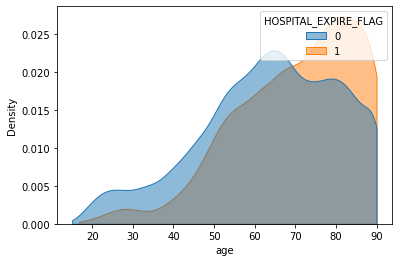

In [27]:
sns.kdeplot(data=df, x="age", hue="HOSPITAL_EXPIRE_FLAG", cut=0, fill=True, common_norm=False, alpha=0.5)
#older patients are more likely to die

In [28]:
#doing the same for test set
df_test['age'] = df_test.age.where(df_test['age']<89, None)
df_test['age'] = df_test['age'].fillna(90)
column = df_test['age']
max_value = column.max()
print(max_value)

90.0


## Data Wrangling on Commorbidity Dataset

We look at how we could incorporate the extra comorbidity dataset.

In [29]:
comorbidity.shape
#we see that one the data is entered in a different format 
#multiple rows corresponding to one patient

(651047, 4)

In [30]:
comorbidity.head()

,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,256,108811,1.0,53240
1,256,108811,2.0,41071
2,256,108811,3.0,53560
3,256,108811,4.0,40390
4,256,108811,5.0,5859


### Incorporating first few comorbidities a patient has

In addition to the main diagnosis, we also look at the second to fourth diagnosis of each patient.

In [31]:
comorbidity.columns = ['subject_id', 'hadm_id', 'SEQ_NUM', 'ICD9_diagnosis']

In [32]:
df_comorbidity = comorbidity.pivot(index=['subject_id', 'hadm_id'], columns='SEQ_NUM')['ICD9_diagnosis'].reset_index()
df_comorbidity.set_index('subject_id', inplace=True)

In [33]:
print(df_comorbidity.shape)
df_comorbidity.head()

(58976, 41)


SEQ_NUM,hadm_id,NaN,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,...,30.0,31.0,32.0,33.0,34.0,35.0,36.0,37.0,38.0,39.0
subject_id,,,,,,,,,,,,,,,,,,,,,
2,163353,NaN,V3001,V053,V290,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,145834,NaN,0389,78559,5849,4275,41071,4280,6826,4254,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,185777,NaN,042,1363,7994,2763,7907,5715,04111,V090,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,178980,NaN,V3000,V053,V290,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,107064,NaN,40391,4440,9972,2766,2767,2859,2753,V1582,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
# we need to retain only subject IDs /observations that is in our main df
#storing the subject_ids of those in the main df
df_all = pd.concat([df.drop(["HOSPITAL_EXPIRE_FLAG"], axis = 1), df_test], axis=0)
print(df_all.shape)
subjects = df_all["subject_id"]

#we drop he columns we won't need so it's easier to see the extra data (comorbidity)
print(df_comorbidity.shape)

df_comorbidity.rename(columns={1.0:'A', 2.0:'B',3.0:'C',4.0:'D',}, inplace=True)
df_comorbidity = df_comorbidity[['B', 'C', 'D', 'hadm_id']]
df_comorbidity.head()

(26106, 40)
(58976, 41)


SEQ_NUM,B,C,D,hadm_id
subject_id,,,,
2,V053,V290,NaN,163353
3,78559,5849,4275,145834
4,1363,7994,2763,185777
5,V053,V290,NaN,178980
6,4440,9972,2766,107064


In [35]:
df = df.merge(df_comorbidity, on = ['hadm_id'], how = 'left')
df_test = df_test.merge(df_comorbidity, on = ['hadm_id'], how = 'left')


print(df.shape)
print(df_test.shape)
df.head()

(20885, 44)
(5221, 43)


,HOSPITAL_EXPIRE_FLAG,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,...,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,ICD9_diagnosis,FIRST_CAREUNIT,age,B,C,D
0,0,55440,195768,228357,89.0,145.0,121.043478,74.0,127.0,106.586957,...,PROTESTANT QUAKER,SINGLE,WHITE,GASTROINTESTINAL BLEED,5789,MICU,69.608219,51881,41071,42831
1,0,76908,126136,221004,63.0,110.0,79.117647,89.0,121.0,106.733333,...,UNOBTAINABLE,MARRIED,WHITE,ESOPHAGEAL FOOD IMPACTION,53013,MICU,42.104110,9351,E915,NaN
2,0,95798,136645,296315,81.0,98.0,91.689655,88.0,138.0,112.785714,...,PROTESTANT QUAKER,SEPARATED,BLACK/AFRICAN AMERICAN,UPPER GI BLEED,56983,MICU,68.210959,56729,5845,5789
3,0,40708,102505,245557,76.0,128.0,98.857143,84.0,135.0,106.972973,...,NOT SPECIFIED,WIDOWED,WHITE,HIATAL HERNIA/SDA,5533,SICU,74.961644,48242,5163,4280
4,0,28424,127337,225281,NaN,NaN,NaN,NaN,NaN,NaN,...,JEWISH,WIDOWED,WHITE,ABDOMINAL PAIN,56211,TSICU,79.424658,5185,9973,5180


It is important to note, however, that incorporating the data this way did not improve my AUC. This may be because there are still too many unique diagnosis per row and that the algorithm cannot capture the variations properly (data due too many unique observations, algortithm find it difficult to find patterns.)

### Total Number of Prior Hospital Admissions

As mentioned previously, some patients have been admitted to the hospital several times. This may be indicative that the patient's illness/es is/are so grave that they have to go to be rushed back to the hospital multiple times. These same patients have a higher risk of dying. 

To extract this data, we count the number of "hadm_id" each subject has. We group by subject_id and hadm_id, and then do a cumulative count within groups.

In [36]:
print(len(df["subject_id"].unique()))
print(len(df["hadm_id"].unique()))

#frequency of visits to ICU
#cumcount counts the number of times the patient has been to the hospital at the time of visit
df['repeat_admissions'] = df.groupby(['hadm_id']).cumcount()
df_test['repeat_admissions'] = df_test.groupby(['hadm_id']).cumcount()

#same number of columns except label
print(df.shape)
print(df_test.shape)
df.head()

16317
19749
(20885, 45)
(5221, 44)


,HOSPITAL_EXPIRE_FLAG,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,...,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,ICD9_diagnosis,FIRST_CAREUNIT,age,B,C,D,repeat_admissions
0,0,55440,195768,228357,89.0,145.0,121.043478,74.0,127.0,106.586957,...,SINGLE,WHITE,GASTROINTESTINAL BLEED,5789,MICU,69.608219,51881,41071,42831,0
1,0,76908,126136,221004,63.0,110.0,79.117647,89.0,121.0,106.733333,...,MARRIED,WHITE,ESOPHAGEAL FOOD IMPACTION,53013,MICU,42.104110,9351,E915,NaN,0
2,0,95798,136645,296315,81.0,98.0,91.689655,88.0,138.0,112.785714,...,SEPARATED,BLACK/AFRICAN AMERICAN,UPPER GI BLEED,56983,MICU,68.210959,56729,5845,5789,0
3,0,40708,102505,245557,76.0,128.0,98.857143,84.0,135.0,106.972973,...,WIDOWED,WHITE,HIATAL HERNIA/SDA,5533,SICU,74.961644,48242,5163,4280,0
4,0,28424,127337,225281,NaN,NaN,NaN,NaN,NaN,NaN,...,WIDOWED,WHITE,ABDOMINAL PAIN,56211,TSICU,79.424658,5185,9973,5180,0


### Number of Diagnoses per Visit

We observe that for each patient, there are different diagnosis and number of diagnoses. This information is available from the comorbidity dataset. Those who have more kinds of illnesses are more likely to die.

The variable "SEQ NUM" tells us the number of diagnoses per visit. From the comorbidities dataset, we can extract a count of diagnoses per visit by getting the maximum SEQ_NUM. 

In [37]:
#DIAGNOSES - count diagnoses by patient per hospital visit

# SEQ_NUM counts the diagnosis that each patient has per hospital admission
# the maximum SEQ_NUM is the total number of comorboidities that a patient has
comorbidity_per_visit = comorbidity[['hadm_id', 'SEQ_NUM']].groupby(['hadm_id'], sort = False).max()

print(comorbidity_per_visit.shape)
comorbidity_per_visit.head()

(58976, 1)


,SEQ_NUM
hadm_id,
108811,11.0
153771,9.0
155415,6.0
188869,14.0
102509,4.0


In [38]:
# Merge into the main main dataframe based on hospital admission
# Hospital admission is the unique identifier that we have since a patient could be included in 
# the main dataframe multiple times if she has been admitted repeatedly
df = df.merge(comorbidity_per_visit, on = ['hadm_id'], how = 'left')
df_test = df_test.merge(comorbidity_per_visit, on = ['hadm_id'], how = 'left')

#same number of columns except label
print(df.shape)
print(df_test.shape)
df.head()

(20885, 46)
(5221, 45)


,HOSPITAL_EXPIRE_FLAG,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,...,ETHNICITY,DIAGNOSIS,ICD9_diagnosis,FIRST_CAREUNIT,age,B,C,D,repeat_admissions,SEQ_NUM
0,0,55440,195768,228357,89.0,145.0,121.043478,74.0,127.0,106.586957,...,WHITE,GASTROINTESTINAL BLEED,5789,MICU,69.608219,51881,41071,42831,0,17.0
1,0,76908,126136,221004,63.0,110.0,79.117647,89.0,121.0,106.733333,...,WHITE,ESOPHAGEAL FOOD IMPACTION,53013,MICU,42.104110,9351,E915,NaN,0,3.0
2,0,95798,136645,296315,81.0,98.0,91.689655,88.0,138.0,112.785714,...,BLACK/AFRICAN AMERICAN,UPPER GI BLEED,56983,MICU,68.210959,56729,5845,5789,0,14.0
3,0,40708,102505,245557,76.0,128.0,98.857143,84.0,135.0,106.972973,...,WHITE,HIATAL HERNIA/SDA,5533,SICU,74.961644,48242,5163,4280,0,15.0
4,0,28424,127337,225281,NaN,NaN,NaN,NaN,NaN,NaN,...,WHITE,ABDOMINAL PAIN,56211,TSICU,79.424658,5185,9973,5180,0,16.0


### ICD9 Codes

As we will see later, there are around 6000 unique diagnoses. We cannot just encode these categories as is. We partly solve this problem later on by using Binary Enocder instead so I could choose the number of columns that would represent some the unique categories.

However, in addition to the step above, it would be valuable to get which illnesses are more deadly. Per type of diagnosis, we get the proportion of patients who had this diagnosis died. This is intuitive as some illenesses are more deadly than others.

Since each patient has several diagnosis, we get the proportion in the sample who had this diagnosis who died. Instead of encoding all how deadly all the diseases are for each patient, we only get the most deadly diagnosis, the median, and the mean (relative to the diagnosis of this patient), as well as the sum of the death rates all dieases a patient has. The death rates for each ICD9_diagnosis is the proportion of deaths for a certain diagnosis divided by the total count of the same diagnoses.

In [41]:
# We create a new dataframe that combines the comorbidity dataframe and whether the subject has died or not
data_diagnoses_all = comorbidity.merge(df[['hadm_id', 'HOSPITAL_EXPIRE_FLAG']], on = ['hadm_id'], how = 'left')
data_diagnoses_all.head()

,subject_id,hadm_id,SEQ_NUM,ICD9_diagnosis,HOSPITAL_EXPIRE_FLAG
0,256,108811,1.0,53240,0.0
1,256,108811,2.0,41071,0.0
2,256,108811,3.0,53560,0.0
3,256,108811,4.0,40390,0.0
4,256,108811,5.0,5859,0.0


In [42]:
# Count deaths and survivals by ICD9_diagnosis
most_deadly = data_diagnoses_all.groupby('ICD9_diagnosis')['HOSPITAL_EXPIRE_FLAG'].sum()
most_deadly = pd.DataFrame(most_deadly)
#we observe that some types of illnesses are not deadly at all
 
most_deadly.head()

,HOSPITAL_EXPIRE_FLAG
ICD9_diagnosis,
0030,0.0
0031,0.0
0038,0.0
0039,0.0
0041,0.0


In [43]:
#counting the number of unique subject id's that had the disease
data_diagnoses_all_2 = data_diagnoses_all.set_index(["ICD9_diagnosis"])
most_deadly_2 = data_diagnoses_all.groupby(['ICD9_diagnosis', 'subject_id'])['subject_id'].nunique()
most_deadly_2 = pd.DataFrame(most_deadly_2)

most_deadly_2.head()

subject_id
ICD9_diagnosis subject_id            
0030           27367                1
               65733                1
0031           69141                1
0038           44437                1
               83908                1

In [44]:
most_deadly_2 = most_deadly_2.groupby('ICD9_diagnosis')['subject_id'].sum().reset_index()
most_deadly_2.rename(columns={'subject_id':'tot_patients'}, inplace=True)

# Merge total deaths and total patients with certain illness
most_deadly = most_deadly.merge(most_deadly_2[['ICD9_diagnosis', 'tot_patients']], on = 'ICD9_diagnosis', how = 'left')

most_deadly.rename(columns={'HOSPITAL_EXPIRE_FLAG':'Died'}, inplace=True)
most_deadly.head(20)

,ICD9_diagnosis,Died,tot_patients
0,0030,0.0,2
1,0031,0.0,1
2,0038,0.0,2
3,0039,0.0,1
4,0041,0.0,3
5,0048,0.0,1
6,0049,0.0,1
7,0051,0.0,1
8,00581,0.0,2
9,0059,0.0,1


In [45]:
# Calculate death rates
most_deadly['how_deadly'] = most_deadly['Died']/most_deadly['tot_patients']
most_deadly = most_deadly.reset_index(drop = False)

# Merge death rates in with comorbidities data
data_diagnoses_all = data_diagnoses_all.merge(most_deadly[['ICD9_diagnosis', 'how_deadly']], on = 'ICD9_diagnosis', how = 'left')

# Max, mean and median death rates per patient 
data_death_rates = data_diagnoses_all.groupby(['hadm_id']).agg(max_death_rate = pd.NamedAgg('how_deadly', 'max'),
                                                               mean_death_rate = pd.NamedAgg('how_deadly', 'mean'),
                                                               median_death_rate = pd.NamedAgg('how_deadly', 'median'),
                                                              sum_death_rate = pd.NamedAgg('how_deadly', 'sum'))


# Merge into main data
df = df.merge(data_death_rates, on = ['hadm_id'], how = 'left')
df_test = df_test.merge(data_death_rates, on = ['hadm_id'], how = 'left')

#same number of columns except label
print(df.shape)
print(df_test.shape)
df.head()

(20885, 50)
(5221, 49)


,HOSPITAL_EXPIRE_FLAG,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,...,age,B,C,D,repeat_admissions,SEQ_NUM,max_death_rate,mean_death_rate,median_death_rate,sum_death_rate
0,0,55440,195768,228357,89.0,145.0,121.043478,74.0,127.0,106.586957,...,69.608219,51881,41071,42831,0,17.0,0.158655,0.077453,0.072539,1.316697
1,0,76908,126136,221004,63.0,110.0,79.117647,89.0,121.0,106.733333,...,42.104110,9351,E915,NaN,0,3.0,0.113861,0.042583,0.013889,0.127750
2,0,95798,136645,296315,81.0,98.0,91.689655,88.0,138.0,112.785714,...,68.210959,56729,5845,5789,0,14.0,0.200000,0.098436,0.100081,1.378099
3,0,40708,102505,245557,76.0,128.0,98.857143,84.0,135.0,106.972973,...,74.961644,48242,5163,4280,0,15.0,0.174194,0.075690,0.062762,1.135346
4,0,28424,127337,225281,NaN,NaN,NaN,NaN,NaN,NaN,...,79.424658,5185,9973,5180,0,16.0,0.120098,0.067231,0.067985,2.151378


In [46]:
data_diagnoses_all.head()

,subject_id,hadm_id,SEQ_NUM,ICD9_diagnosis,HOSPITAL_EXPIRE_FLAG,how_deadly
0,256,108811,1.0,53240,0.0,0.076046
1,256,108811,2.0,41071,0.0,0.050842
2,256,108811,3.0,53560,0.0,0.053333
3,256,108811,4.0,40390,0.0,0.116714
4,256,108811,5.0,5859,0.0,0.099725


### Dropping some columns

In [47]:
df.columns

Index(['HOSPITAL_EXPIRE_FLAG', 'subject_id', 'hadm_id', 'icustay_id',
       'HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min',
       'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean',
       'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min',
       'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean',
       'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max',
       'Glucose_Mean', 'GENDER', 'DOB', 'ADMITTIME', 'Diff', 'ADMISSION_TYPE',
       'INSURANCE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'DIAGNOSIS',
       'ICD9_diagnosis', 'FIRST_CAREUNIT', 'age', 'B', 'C', 'D',
       'repeat_admissions', 'SEQ_NUM', 'max_death_rate', 'mean_death_rate',
       'median_death_rate', 'sum_death_rate'],
      dtype='object')

In [48]:
#drop variables not known on the first day, variable id's, and duplicate columns
to_drop = ['subject_id', 'hadm_id', 'icustay_id', 'DOB', 'ADMITTIME', 'Diff']
df = df.drop(to_drop,axis=1)
df_test = df_test.drop(to_drop,axis=1)
print(df.shape)
print(df_test.shape)

(20885, 44)
(5221, 43)


## Feature Engineering

### Handling Missing Values

In [49]:
#counting the rows with missing values
is_NaN = df.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = df[row_has_NaN]
print(rows_with_NaN.shape)

is_NaN = df_test.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = df_test[row_has_NaN]
print(rows_with_NaN.shape)

(3747, 44)
(945, 43)


At first, I thought the the data were missing at random. However, looking at the dataframe, those who have missing value in one column are oftentimes the same people with missing values for other column.
Therefore, I am more inclined to identify this missingness as structural.
The data is missing for an apparent and/or logical reason, with easily inferred mechanism (unlike missing not at random)

What I will do is impute the median for these values, and then add another column indicating the missingness of a certain feature. 

In [50]:
df.columns[df.isnull().any()]

#Most of the missing values has to do with vital statistics. 

Index(['HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min',
       'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean',
       'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min',
       'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean',
       'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max',
       'Glucose_Mean', 'MARITAL_STATUS', 'B', 'C', 'D'],
      dtype='object')

In [51]:
df.dtypes #we need to convert strings to categories later on

HOSPITAL_EXPIRE_FLAG      int64
HeartRate_Min           float64
HeartRate_Max           float64
HeartRate_Mean          float64
SysBP_Min               float64
SysBP_Max               float64
SysBP_Mean              float64
DiasBP_Min              float64
DiasBP_Max              float64
DiasBP_Mean             float64
MeanBP_Min              float64
MeanBP_Max              float64
MeanBP_Mean             float64
RespRate_Min            float64
RespRate_Max            float64
RespRate_Mean           float64
TempC_Min               float64
TempC_Max               float64
TempC_Mean              float64
SpO2_Min                float64
SpO2_Max                float64
SpO2_Mean               float64
Glucose_Min             float64
Glucose_Max             float64
Glucose_Mean            float64
GENDER                   object
ADMISSION_TYPE           object
INSURANCE                object
RELIGION                 object
MARITAL_STATUS           object
ETHNICITY                object
DIAGNOSI

In [52]:
df["MARITAL_STATUS"].unique()

array(['SINGLE', 'MARRIED', 'SEPARATED', 'WIDOWED', 'DIVORCED', nan,
       'UNKNOWN (DEFAULT)', 'LIFE PARTNER'], dtype=object)

In [53]:
#first we deal with marital status missing
# there is a category of unknown, so i'll fill the missing values with that category
df['MARITAL_STATUS'] = df['MARITAL_STATUS'].fillna('UNKNOWN (DEFAULT)')
df_test['MARITAL_STATUS'] = df_test['MARITAL_STATUS'].fillna('UNKNOWN (DEFAULT)')

Now we deal with missing vital statistics. It is better to use the median as we are taking out outliers. The median is a good representation of the population since this is a big dataset.

In [54]:
#converting the HOSPITAL_EXPIRE_FLAG to categorical variable
df['HOSPITAL_EXPIRE_FLAG'] = pd.Categorical(df.HOSPITAL_EXPIRE_FLAG)
df['HOSPITAL_EXPIRE_FLAG'] = df.HOSPITAL_EXPIRE_FLAG.cat.codes

In [55]:
for my_df in [df, df_test]:
    for col in ["GENDER", "INSURANCE", "RELIGION", "MARITAL_STATUS", "ETHNICITY", "FIRST_CAREUNIT", "ADMISSION_TYPE", "DIAGNOSIS", "ICD9_diagnosis", "B", "C", "D"]:
        my_df[col] = my_df[col].astype('category')
        my_df[col] = pd.factorize(my_df[col], sort=True)[0] + 1 

In [56]:
df.dtypes

HOSPITAL_EXPIRE_FLAG       int8
HeartRate_Min           float64
HeartRate_Max           float64
HeartRate_Mean          float64
SysBP_Min               float64
SysBP_Max               float64
SysBP_Mean              float64
DiasBP_Min              float64
DiasBP_Max              float64
DiasBP_Mean             float64
MeanBP_Min              float64
MeanBP_Max              float64
MeanBP_Mean             float64
RespRate_Min            float64
RespRate_Max            float64
RespRate_Mean           float64
TempC_Min               float64
TempC_Max               float64
TempC_Mean              float64
SpO2_Min                float64
SpO2_Max                float64
SpO2_Mean               float64
Glucose_Min             float64
Glucose_Max             float64
Glucose_Mean            float64
GENDER                    int64
ADMISSION_TYPE            int64
INSURANCE                 int64
RELIGION                  int64
MARITAL_STATUS            int64
ETHNICITY                 int64
DIAGNOSI

### Imputing

<span style="color:red">**NEW!!**</span> **KNN Imputer**

The idea in kNN methods is to identify ‘k’ samples in the dataset that are similar or close in the space. Then we use these ‘k’ samples to estimate the value of the missing data points. Each sample’s missing values are imputed using the mean value of the ‘k’-neighbors found in the dataset.

Source: https://www.analyticsvidhya.com/blog/2020/07/knnimputer-a-robust-way-to-impute-missing-values-using-scikit-learn/#:~:text=The%20idea%20in%20kNN%20methods,neighbors%20found%20in%20the%20dataset.

In [57]:
#splitting to labels and features

y_train = df['HOSPITAL_EXPIRE_FLAG']  # survived or did not survive
X_train = df.drop(['HOSPITAL_EXPIRE_FLAG'], axis=1)

X_train_columns = X_train.columns

imp = KNNImputer(missing_values=np.nan, n_neighbors = 150, weights = 'distance', add_indicator = False)
#I have arbitrarily set the number of neighbors based on the size of the dataset and then neighbors returned from the grid search
#imp = SimpleImputer(missing_values=np.nan, strategy='median')
#imputing using the median

imp.fit(X_train)
X_train = imp.transform(X_train)

X_test_orig = df_test.copy()
X_test = df_test
X_test_columns = X_test.columns
X_test = imp.transform(X_test)

print(pd.DataFrame(X_train).shape)
print(pd.DataFrame(X_test).shape)

X_train = pd.DataFrame(X_train)
X_train.columns = X_train_columns

X_test = pd.DataFrame(X_test)
X_test.columns = X_test_columns

(20885, 43)
(5221, 43)


### Polynomial Features

In [58]:
X_train["age_2"] = X_train["age"]**2
X_test["age_2"] = X_test["age"]**2

X_train["HeartRate_Mean_2"] = X_train["HeartRate_Mean"]**2
X_test["HeartRate_Mean_2"] = X_test["HeartRate_Mean"]**2

X_train["SysBP_Mean_2"] = X_train["MeanBP_Mean"]**2
X_test["SysBP_Mean_2"] = X_test["MeanBP_Mean"]**2

X_train["RespRate_Mean_2"] = X_train["RespRate_Mean"]**2
X_test["RespRate_Meann_2"] = X_test["RespRate_Mean"]**2

X_train["TempC_Mean_2"] = X_train["TempC_Mean"]**2
X_test["TempC_Mean_2"] = X_test["TempC_Mean"]**2

X_train["SpO2_Mean_2"] = X_train["SpO2_Mean"]**2
X_test["SpO2_Mean_2"] = X_test["SpO2_Mean"]**2

X_train["Glucose_Mean_2"] = X_train["Glucose_Mean"]**2
X_test["Glucose_Mean_2"] = X_test["Glucose_Mean"]**2

#'HeartRate_Mean','SysBP_Mean', 'DiasBP_Mean', 'MeanBP_Mean', 'RespRate_Mean', 'TempC_Mean', 'SpO2_Mean', 'Glucose_Mean'

#Add interactions

#'HeartRate_Max','SysBP_Max', 'DiasBP_Max', 'MaxBP_Max', 'RespRate_Max', 'TempC_Max', 'SpO2_Max', 'Glucose_Max'
#X_train["HeartRate_Max_age"] = X_train["age"]*X_train['HeartRate_Max']
#X_test["HeartRate_Max_age"] = X_test["age"]*X_test['HeartRate_Max']

#X_train["SysBP_Max_age"] = X_train["age"]*X_train['SysBP_Max']
#X_test["SysBP_Max_age"] = X_test["age"]*X_test['SysBP_Max']

#X_train["DiasBP_Max_age"] = X_train["age"]*X_train['DiasBP_Max']
#X_test["DiasBP_Max_age"] = X_test["age"]*X_test['DiasBP_Max']

#X_train["MeanBP_Max_age"] = X_train["age"]*X_train['MeanBP_Max']
#X_test["MeanBP_Max_age"] = X_test["age"]*X_test['MeanBP_Max']

#X_train["TempC_Max_age"] = X_train["age"]*X_train['TempC_Max']
#X_test["TempC_Max_age"] = X_test["age"]*X_test['TempC_Max']

#X_train["SpO2_Max_age"] = X_train["age"]*X_train['SpO2_Max']
#X_test["SpO2_Max_age"] = X_test["age"]*X_test['SpO2_Max']

#X_train["Glucose_Max_age"] = X_train["age"]*X_train['Glucose_Max']
#X_test["Glucose_Max_age"] = X_test["age"]*X_test['Glucose_Max']

##commenting out interactions as it did not improve my model

X_train = pd.DataFrame(X_train)
X_train_columns = X_train.columns

X_test = pd.DataFrame(X_test)
X_test_columns = X_test.columns

In [59]:
X_train.head()

,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,...,mean_death_rate,median_death_rate,sum_death_rate,age_2,HeartRate_Mean_2,SysBP_Mean_2,RespRate_Mean_2,TempC_Mean_2,SpO2_Mean_2,Glucose_Mean_2
0,89.0000,145.00000,121.043478,74.000000,127.000000,106.586957,42.000000,90.000000,61.173913,59.000000,...,0.077453,0.072539,1.316697,4845.304177,14651.523629,5556.730151,499.425331,1301.784217,9165.981096,25849.493827
1,63.0000,110.00000,79.117647,89.000000,121.000000,106.733333,49.000000,74.000000,64.733333,58.000000,...,0.042583,0.013889,0.127750,1772.756044,6259.602076,5595.040000,257.885813,1330.222994,9812.650519,10609.000000
2,81.0000,98.00000,91.689655,88.000000,138.000000,112.785714,45.000000,67.000000,56.821429,64.000000,...,0.098436,0.100081,1.378099,4652.734915,8406.992866,5312.790123,252.810000,1344.444444,10000.000000,47365.586777
3,76.0000,128.00000,98.857143,84.000000,135.000000,106.972973,30.000000,89.000000,41.864865,48.000000,...,0.075690,0.062762,1.135346,5619.248047,9772.734694,3941.803506,716.709388,1431.361111,9041.293061,15625.000000
4,71.7203,108.94108,87.595716,91.278928,155.317931,120.996092,43.180956,85.418209,61.014893,55.802391,...,0.067231,0.067985,2.151378,6308.276224,7673.009486,5989.922309,346.142369,1354.158231,9392.740550,12769.000000


In [60]:
X_test.head()

,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,...,mean_death_rate,median_death_rate,sum_death_rate,age_2,HeartRate_Mean_2,SysBP_Mean_2,RespRate_Meann_2,TempC_Mean_2,SpO2_Mean_2,Glucose_Mean_2
0,58.0,90.0,85.244898,77.0,153.0,98.490909,40.0,77.0,52.018182,53.0,...,0.061069,0.055521,1.221376,6659.454277,7266.692628,4651.240000,151.145329,1399.145176,9838.951562,18139.836565
1,91.0,145.0,115.055556,73.0,143.0,101.210526,42.0,86.0,65.578947,50.0,...,0.116267,0.124821,1.278938,2344.151503,13237.780864,7225.000000,681.082689,1431.361111,9538.777778,153292.855956
2,106.0,132.0,117.750000,93.0,137.0,116.222222,51.0,76.0,66.703704,60.0,...,0.078325,0.058353,0.939899,1781.765052,13865.062500,5982.427515,487.147959,1473.050643,9194.679012,15129.000000
3,72.0,105.0,83.627119,72.0,168.0,126.981818,39.0,99.0,62.854545,46.0,...,0.076929,0.069826,1.230865,7115.962470,6993.494973,6162.250000,196.000000,1363.684908,9076.892562,21682.562500
4,85.0,124.0,98.600000,86.0,144.0,110.666667,52.0,133.0,72.833333,66.0,...,0.077343,0.079185,2.242937,2812.195429,9721.960000,7467.840278,583.767950,1342.698980,9216.000000,24180.250000


### Standardizing

In [61]:
# Rescale data inputs
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()

scaler.fit(X_train)## Fitted to the training set
X_train = scaler.transform(X_train)

X_test = scaler.transform(X_test)

In [62]:
X_train = pd.DataFrame(X_train)
X_train.columns = X_train_columns

pd.DataFrame(X_train).isnull().sum()
#no null values

X_test = pd.DataFrame(X_test)
X_test.columns = X_test_columns

pd.DataFrame(X_test).isnull().sum()
#no null values

print(X_train.shape)
print(X_test.shape)

(20885, 50)
(5221, 50)


### Creating Dummies & Encoding

In [63]:
cat_columns = ['GENDER', 'ADMISSION_TYPE', 'INSURANCE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'FIRST_CAREUNIT', 'DIAGNOSIS', 'ICD9_diagnosis', 'B', 'C', 'D']
df_cat = df[cat_columns]

print(df_cat.nunique())

to_dummy = ['GENDER', 'ADMISSION_TYPE', 'INSURANCE', 'MARITAL_STATUS', 'FIRST_CAREUNIT']
to_encode = ['RELIGION', 'ETHNICITY', 'DIAGNOSIS', 'ICD9_diagnosis', 'B', 'C', 'D']

GENDER               2
ADMISSION_TYPE       3
INSURANCE            5
RELIGION            17
MARITAL_STATUS       7
ETHNICITY           41
FIRST_CAREUNIT       5
DIAGNOSIS         6193
ICD9_diagnosis    1853
B                 1572
C                 1928
D                 2034
dtype: int64


In [64]:
# get dummies/binary encoding 
X_train = pd.get_dummies(X_train, columns = to_dummy, drop_first = True)
X_test = pd.get_dummies(X_test, columns = to_dummy, drop_first = True)

encoder = ce.BinaryEncoder(cols=to_encode)
encoder = encoder.fit(df[to_encode])
X_train = pd.concat([X_train.drop(columns=to_encode), encoder.transform(X_train[to_encode])], axis=1)
X_test = pd.concat([X_test.drop(columns=to_encode), encoder.transform(X_test[to_encode])], axis=1)

print(X_train.shape)
print(X_test.shape)

(20885, 123)
(5221, 123)


In [65]:
X_train.head()

,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,...,D_1,D_2,D_3,D_4,D_5,D_6,D_7,D_8,D_9,D_10
0,1.374333,2.010394,2.474651,-1.028574,-1.053042,-0.793270,-0.203326,0.092194,-0.123758,0.199893,...,0,0,0,0,0,0,0,0,0,0
1,-0.469119,0.245875,-0.410564,-0.126071,-1.318814,-0.784030,0.416908,-0.783446,0.217013,0.126362,...,0,0,0,0,0,0,0,0,0,0
2,0.807117,-0.359103,0.454606,-0.186238,-0.565793,-0.401949,0.062489,-1.166539,-0.540454,0.567553,...,0,0,0,0,0,0,0,0,0,0
3,0.452607,1.153342,0.947852,-0.426905,-0.698679,-0.768902,-1.266584,0.037466,-1.972360,-0.608957,...,0,0,0,0,0,0,0,0,0,0
4,0.149168,0.192490,0.172873,0.011045,0.201310,0.116364,-0.098687,-0.158556,-0.138982,-0.035233,...,0,0,0,0,0,0,0,0,0,0


In [66]:
X_test.head()

,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,...,D_1,D_2,D_3,D_4,D_5,D_6,D_7,D_8,D_9,D_10
0,-0.823629,-0.762421,0.011096,-0.848073,0.098636,-1.304366,-0.380535,-0.619264,-1.000306,-0.241298,...,0,0,0,0,0,0,0,0,0,0
1,1.516137,2.010394,2.062580,-1.088741,-0.344317,-1.132679,-0.203326,-0.126716,0.297970,-0.461893,...,0,0,0,0,0,0,0,0,0,0
2,2.579667,1.355002,2.248004,0.114596,-0.610089,-0.185006,0.594118,-0.673991,0.405651,0.273425,...,0,0,0,0,0,0,0,0,0,0
3,0.168999,-0.006199,-0.100235,-1.148907,0.763066,0.494236,-0.469140,0.584741,0.037142,-0.756020,...,0,0,0,0,0,0,0,0,0,0
4,1.090725,0.951683,0.930156,-0.306572,-0.300022,-0.535723,0.682723,2.445476,0.992488,0.714616,...,0,0,0,0,0,0,0,0,0,0


# KNN

# Step 4: Build your model and get predictions from train data

In [67]:
#Do KNN

# define model
my_knn = KNeighborsClassifier()

# define evaluation
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state=3997)
# define search space
space = dict()
space['metric'] = ['minkowski', 'manhattan']
space['algorithm'] = ['brute', 'ball_tree', 'kd_tree'] #same as auto
space['n_neighbors'] = [100,200,300,350,400] #have included 20, 50 before
space['weights'] = ['uniform','distance']

# define search
search = RandomizedSearchCV(my_knn, space, n_iter=10, scoring='roc_auc', n_jobs=3, cv=cv, random_state=1, verbose=10)
# execute search
result = search.fit(X_train, y_train)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Fitting 6 folds for each of 10 candidates, totalling 60 fits
Best Score: 0.9224420431670648
Best Hyperparameters: {'weights': 'distance', 'n_neighbors': 300, 'metric': 'manhattan', 'algorithm': 'ball_tree'}


In [ ]:
# model 1
my_knn_1 = KNeighborsClassifier(n_neighbors=20, weights='distance', algorithm = 'kd_tree')
my_knn_1.fit(X_train, y_train)

# saving our model # model - model , filename-model_jlib
#joblib.dump(my_knn_1, 'my_knn_1_jlib')

# opening the file- model_jlib
#my_knn_1_jlib = joblib.load('my_knn_1_jlib')

# check prediction
my_knn_1_jlib.predict(X_train)

In [ ]:
# model 2
my_knn_2 = KNeighborsClassifier(n_neighbors=50, weights='distance', algorithm = 'ball_tree')
my_knn_2.fit(X_train, y_train)

# saving our model # model - model , filename-model_jlib
#joblib.dump(my_knn_2, 'my_knn_2_jlib')

# opening the file- model_jlib
#my_knn_2_jlib = joblib.load('my_knn_2_jlib')

#Results
#Best Score: 0.9174607661615437
#Best Hyperparameters: {'weights': 'distance', 'n_neighbors': 20, 'algorithm': 'kd_tree'}

In [ ]:
# model 3
my_knn_3 = KNeighborsClassifier(n_neighbors=20, weights='distance', algorithm = 'kd_tree')
my_knn_3.fit(X_train, y_train)

# saving our model # model - model , filename-model_jlib
#joblib.dump(my_knn_3, 'my_knn_3_jlib')

# opening the file- model_jlib
#my_knn_3_jlib = joblib.load('my_knn_3_jlib')

#Results
#Fitting 6 folds for each of 10 candidates, totalling 60 fits
#Best Score: 0.9373479502404978
#Best Hyperparameters: {'weights': 'distance', 'n_neighbors': 100, 'algorithm': 'ball_tree'}

In [ ]:
# model 4
my_knn_4 = KNeighborsClassifier(n_neighbors=100, weights='distance', algorithm = 'ball_tree')
my_knn_4.fit(X_train, y_train)

# saving our model # model - model , filename-model_jlib
#joblib.dump(my_knn_4, 'my_knn_4_jlib')

# opening the file- model_jlib
#my_knn_4_jlib = joblib.load('my_knn_4_jlib')

In [ ]:
# model 5
my_knn_5 = KNeighborsClassifier(n_neighbors=300, weights='distance', algorithm = 'ball_tree')
my_knn_5.fit(X_train, y_train)

# saving our model # model - model , filename-model_jlib
#joblib.dump(my_knn_5, 'my_knn_5_jlib')

# opening the file- model_jlib
#my_knn_5_jlib = joblib.load('my_knn_5_jlib')

In [64]:
my_knn_6 = KNeighborsClassifier(n_neighbors=350, weights='distance', algorithm = 'ball_tree')
my_knn_6.fit(X_train, y_train)

#my_knn_6.predict_proba(X_train)

## In-sample
print(roc_auc_score(y_train, my_knn_6.predict_proba(X_train)[:, 1]))

KNeighborsClassifier(algorithm='ball_tree', n_neighbors=350, weights='distance')

In [65]:
my_knn_8 = KNeighborsClassifier(n_neighbors=400, weights='distance', algorithm = 'kd_tree', metric='manhattan')
my_knn_8.fit(X_train, y_train)

## In-sample
print(roc_auc_score(y_train, my_knn_8.predict_proba(X_train)[:, 1]))

In [68]:
my_knn_9 = KNeighborsClassifier(n_neighbors=300, weights='distance', algorithm = 'ball_tree', metric='manhattan')
my_knn_9.fit(X_train, y_train)

## In-sample
print(roc_auc_score(y_train, my_knn_9.predict_proba(X_train)[:, 1]))

1.0


# Step 5: Assess feature importance (if possible)

"Feature importance is not defined for the KNN Classification algorithm". 

Source: https://stackoverflow.com/questions/55314345/how-to-find-feature-importance-or-variable-importance-graph-for-knnclassifier#:~:text=If%20you%20are%20set%20on,feature%20(call%20these%20neighb_dist%20).

# Step 6: Applying to test set

Steps applied to training set have been applied to test set immediately afterwards (see previous steps)

In [69]:
y_pred_proba = my_knn_9.predict_proba(X_test)
y_pred_proba

array([[1.        , 0.        ],
       [0.88248688, 0.11751312],
       [0.99061013, 0.00938987],
       ...,
       [0.93389696, 0.06610304],
       [0.99686052, 0.00313948],
       [0.99403659, 0.00596341]])

# Step 7: Class imbalance management

Random oversampler and undersampler. I am coding this manually to have full control on the sampling. Forr the SVM part, I'll be using just the RandomOverSampler from imblearn.

In [70]:
X_train_1 = pd.concat([X_train, df['HOSPITAL_EXPIRE_FLAG']], axis=1)
X_train_1 = pd.concat([X_train_1, df_orig['hadm_id']], axis=1)

y_train_1 = pd.concat([y_train, df_orig['hadm_id']], axis=1)

# store into dataframes based on hospital expire flag
df_type_0 = X_train_1[X_train_1['HOSPITAL_EXPIRE_FLAG'] == 0]
df_type_1 = X_train_1[X_train_1['HOSPITAL_EXPIRE_FLAG'] == 1]
y_type_0 = y_train_1[y_train_1['HOSPITAL_EXPIRE_FLAG'] == 0]
y_type_1 = y_train_1[y_train_1['HOSPITAL_EXPIRE_FLAG'] == 1]

print(df_type_0.shape)
print(df_type_1.shape)

# Undersample type 1, reduce by 50%
print(18540/2)
df_type_0_under = df_type_0.sample(9270,  random_state=23)
y_train_0_under =  y_type_0.sample(9270,  random_state=23)
y_train_0_under =  y_train_0_under["HOSPITAL_EXPIRE_FLAG"]

# Oversample TYPE 0, increase by 200%
print(2345*3)
df_type_1_over = df_type_1.sample(7035, replace= True, random_state=23)
y_train_1_over =  y_type_1.sample(7035, replace= True, random_state=23)
y_train_1_over  =  y_train_1_over ["HOSPITAL_EXPIRE_FLAG"]

#X_train_under_over = df_type_0_under.merge(df_type_1_over, on = ['hadm_id'], how = 'left')
X_train_under_over = pd.concat([df_type_0_under, df_type_1_over], axis=0)
y_train_under_over = pd.concat([y_train_0_under, y_train_1_over], axis=0)

X_train_under_over = X_train_under_over.drop(['HOSPITAL_EXPIRE_FLAG', 'hadm_id'], axis=1)

print(X_train_under_over.shape)
print(y_train_under_over.shape)

# We then pass this new resampled data to he grid search, and then refit the model (Step 4 and 6)
# I have done this but will not the show the code anymore for brevity

(18540, 125)
(2345, 125)
9270.0
7035
(16305, 123)
(16305,)


In [71]:
X_train_under_over.head()

,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,...,D_1,D_2,D_3,D_4,D_5,D_6,D_7,D_8,D_9,D_10
11862,-0.327315,-0.308688,-0.703759,-0.547239,-0.300022,-0.397440,-0.557745,0.475286,-1.204919,-0.535425,...,0,0,0,0,0,0,0,0,0,0
19905,-1.249041,-1.165740,-1.532246,1.317933,0.364408,0.926147,0.416908,-0.071989,-0.427621,0.494021,...,0,0,0,0,0,0,0,0,0,0
10074,-1.036335,-0.510347,-0.697945,-0.968407,1.028838,-0.304624,0.239699,0.858379,0.169087,-0.020702,...,0,0,0,0,0,0,0,0,0,0
15748,-0.752727,-0.611177,-0.571834,1.979768,1.073133,1.771025,2.189006,1.515108,2.777939,2.111721,...,0,0,0,0,0,0,0,0,0,0
2052,-1.319943,-0.661592,-0.876919,-0.126071,0.541589,-0.161157,-1.089374,1.734018,-1.474991,-0.608957,...,0,0,0,0,0,0,0,0,0,0


In [72]:
#Do KNN

# define model
my_knn = KNeighborsClassifier()
# define evaluation

cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state=3997)
# define search space
space = dict()
space['algorithm'] = ['minkowski', 'manhattan']
space['algorithm'] = ['brute', 'ball_tree', 'kd_tree'] #same as auto
space['n_neighbors'] = [20,50,100,200,300,350,400]
space['weights'] = ['uniform','distance']

# define search
search = RandomizedSearchCV(my_knn, space, n_iter=10, scoring='roc_auc', n_jobs=3, cv=cv, random_state=1, verbose=10)
# execute search
result = search.fit(X_train_under_over, y_train_under_over)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Fitting 6 folds for each of 10 candidates, totalling 60 fits
Best Score: 0.9897480236358659
Best Hyperparameters: {'weights': 'distance', 'n_neighbors': 300, 'algorithm': 'ball_tree'}


In [73]:
my_knn_7 = KNeighborsClassifier(n_neighbors=350, weights='distance', algorithm = 'kd_tree')
my_knn_7.fit(X_train_under_over, y_train_under_over)

KNeighborsClassifier(algorithm='kd_tree', n_neighbors=350, weights='distance')

In [74]:
y_pred_proba =  my_knn_7.predict_proba(X_train_under_over)

## In-sample
print(roc_auc_score(y_train_under_over, my_knn_7.predict_proba(X_train_under_over)[:, 1]))## In-sample

1.0


In [75]:
y_pred_proba =  my_knn_7.predict_proba(X_test)

In [89]:
my_knn_7a = KNeighborsClassifier(n_neighbors=300, weights='distance', algorithm = 'ball_tree')
my_knn_7a.fit(X_train_under_over, y_train_under_over)

KNeighborsClassifier(algorithm='ball_tree', n_neighbors=300, weights='distance')

In [93]:
y_pred_proba =  my_knn_7a.predict_proba(X_test)

In [94]:
#Check for class imbalance
unique, counts = np.unique(y_train, return_counts=True)
class_counts = dict(zip(unique, counts))

# Calculate class weights
class0 = class_counts[0]/(class_counts[0] + class_counts[1])
class1 = class_counts[1]/(class_counts[0] + class_counts[1])

#Function for re-weighting probabilities to correct for class imbalance. 
def reweight(pi,q1=class1,r1=0.5):
    r0 = 1-r1
    q0 = 1-q1
    tot = pi*(q1/r1)+(1-pi)*(q0/r0)
    w = pi*(q1/r1)
    w /= tot
    return w

In [95]:
X_train_under_over.shape
X_test.shape

(5221, 123)

In [96]:
y_pred_proba = reweight(y_pred_proba)
y_pred_proba

array([[0.88574982, 0.00205929],
       [0.08982297, 0.13949485],
       [0.66773391, 0.00789778],
       ...,
       [0.20417864, 0.0586951 ],
       [0.86418886, 0.00250786],
       [0.85927838, 0.0026131 ]])

# SVM

# Step 4: Build your model and get predictions from train data

In [79]:
#Get best params by doing randomized grid search
from sklearn.svm import SVC # "Support vector classifier"

model = SVC() 

# define evaluation
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state=108)
# define search space
space = dict()
space['kernel'] = ['linear', 'rbf', 'sigmoid']
space['C'] = [0.0001, 0.0005, 0.001, 0.01,0.1,1,2,3]

# define search
search = RandomizedSearchCV(model, space, n_iter=10, scoring='roc_auc', n_jobs=3, cv=cv, random_state=1, verbose=15)
# execute search
result = search.fit(X_train, y_train)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

#have also added other types of kernels instead of just setting it to linear
# i have removed 'precomuputed' cause it requires a square kernel matrix

Fitting 6 folds for each of 10 candidates, totalling 60 fits
Best Score: 0.9319496281579317
Best Hyperparameters: {'kernel': 'linear', 'C': 2}


In [80]:
#Fit SVM

#model 1
#my_svm = SVC(kernel='linear', C=0.01, probability=True)
#my_svm.fit(X_train, y_train)

#model 2
#my_svm = SVC(kernel='rbf', C=1, probability=True)
#my_svm.fit(X_train, y_train)


#model 3 (this performs the best so far)
#my_svm = SVC(kernel='linear', C=0.01, class_weight='balanced')
#my_svm.fit(X_train, y_train)

#model 4 
#my_svm = SVC(kernel='rbf', C=0.1, class_weight='balanced', probability = True)
#my_svm.fit(X_train, y_train)

#model 5 
#my_svm = SVC(kernel='linear', C=1, class_weight='balanced', probability = True)
#my_svm.fit(X_train, y_train)

#model 6
my_svm = SVC(kernel='linear', C=2, probability = True)
my_svm.fit(X_train, y_train)

SVC(C=2, kernel='linear', probability=True)

In [81]:
## In-sample
print(roc_auc_score(y_train, my_svm.predict_proba(X_train)[:, 1]))

#i use predict_proba when i set probability = True
y_pred_proba = my_svm.predict_proba(X_test)

0.9350154566970971


# Step 5: Assess feature importance

In [82]:
def feature_imp(coef, names, top=-1):
    imp = coef
    imp, names = zip(*sorted(list(zip(imp, names))))

    # Show all features
    if top == -1:
        top = len(names)

    plt.barh(range(top), imp[::-1][0:top], align='center')
    plt.yticks(range(top), names[::-1][0:top])
    plt.show()

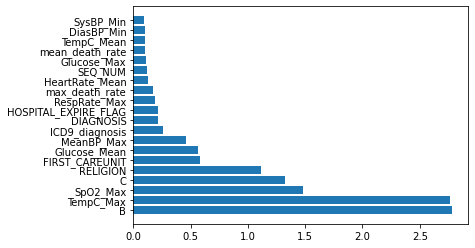

In [83]:
feature_imp(abs(my_svm.coef_[0]), df.columns, top=20)

<span style="color:red">**NEW!!**</span> **Using decision_function**
According to stack, one could disable probability and use decision_function instead,  because there is no guarantee that predict_proba and predict return the same result. 

"Platt’s method is also known to have theoretical issues. If confidence scores are required, but these do not have to be probabilities, then it is advisable to set probability=False and use decision_function instead of predict_proba." Source: https://scikit-learn.org/stable/modules/svm.html#:~:text=Support%20vector%20machines%20(SVMs)%20are,classification%2C%20regression%20and%20outliers%20detection.&text=Uses%20a%20subset%20of%20training,it%20is%20also%20memory%20efficient.

Later on, instead of using decision function, I'll also be reweighting the probabilities I get from pred_proba.

In [84]:
#model 7
my_svm = SVC(kernel='linear', C=2)
my_svm.fit(X_train, y_train)

# i just call it pred_proba even if its from decision function so i don't have to rename the last cell
y_pred_proba = my_svm.decision_function(X_test)

Decision function yield negative probabilities but the AUC returned by Kaggle stayed the same as with havving probability=True and predict_proba

# Step 7: Class imbalance management

In [85]:
sampling_strategy = 0.5
sampling = RandomOverSampler(sampling_strategy = sampling_strategy)
X_train_over, y_train_over = sampling.fit_resample(X_train, y_train) 

In [86]:
#Get best params by doing randomized grid search
from sklearn.svm import SVC # "Support vector classifier"

model = SVC() #note that I have tried both imbalanced and balanced

# define evaluation

cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state=108)
# define search space
space = dict()
space['kernel'] = ['linear', 'rbf', 'sigmoid']
space['C'] = [0.0001, 0.0005, 0.001, 0.01,0.1,1,2,3]

# define search
search = RandomizedSearchCV(model, space, n_iter=10, scoring='roc_auc', n_jobs=3, cv=cv, random_state=1, verbose=15)
# execute search
result = search.fit(X_train_over, y_train_over)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

#have also added other types of kernels instead of just setting it to linear
# i have removed 'precomuputed' cause it requires a square kernel matrix

Fitting 6 folds for each of 10 candidates, totalling 60 fits
Best Score: 0.9616317207961095
Best Hyperparameters: {'kernel': 'rbf', 'C': 2}


In [87]:
my_svm = SVC(kernel='rbf', C=2, probability = True)
my_svm.fit(X_train, y_train)

## In-sample
print(roc_auc_score(y_train, my_svm.predict_proba(X_train)[:, 1]))

#i use predict_proba when i set probability = True
y_pred_proba = my_svm.predict_proba(X_test)

#performed worse than unbalanced in Kaggle competition

0.9669513965079826


### **More new stuff**

<span style="color:red">**NEW!!**</span> **Using the Gram Matrix** 

Address this computational problem by pre-computing the kernel
function for all pairs of training examples in the dataset.
This transforms the learning problem into a simpler minimization of a certain function which is much easier than recomputing the kernel at each iteration

Source: https://www.cs.cornell.edu/courses/cs6787/2017fa/Lecture4.pdf

In [98]:
from sklearn import svm

clf = svm.SVC(kernel='precomputed', probability=True)
# linear kernel computation
gram_train = np.dot(X_train, X_train.T)
clf.fit(gram_train, y_train)
SVC(kernel='precomputed')
# predict on training examples
gram_test = np.dot(X_test, X_train.T)
y_pred_proba = clf.predict_proba(gram_test)

#scored 0.91190 in kaggle but not my best score

The disadvantage of Gram Matrix is that for huge number of observations, it would take very long to train.

<span style="color:red">**NEW!!**</span> **NuSVC** 

Similar to SVC but uses a parameter to control the number of support vectors. Uses nu instead of C.

(from stack)
The problem with the parameter C is:
- that it can take any positive value
- that it has no direct interpretation.
- It is therefore hard to choose correctly and one has to resort to cross validation or direct experimentation to find a suitable value.

In response Schölkopf et al. reformulated SVM to take a new regularization parameter nu. This parameter is:
- bounded between 0 and 1
- has a direct interpretation

Source: https://scikit-learn.org/stable/modules/generated/sklearn.svm.NuSVC.html; https://stackoverflow.com/questions/11230955/what-is-the-meaning-of-the-nu-parameter-in-scikit-learns-svm-class

In [106]:
from sklearn.svm import NuSVC

model = NuSVC()

# define evaluation
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state=138)
# define search space
space = dict()
space['kernel'] = ['rbf']
space['nu'] = [0.01, 0.0005, 0.001, 0.01,0.1,0.2,0.3, 0.8] #parameter nu should be between 0 and 1

# define search
search = RandomizedSearchCV(model, space, n_iter=3, scoring='roc_auc', n_jobs=3, cv=cv, random_state=1, verbose=15)
# execute search
result = search.fit(X_train_over, y_train_over)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Fitting 6 folds for each of 3 candidates, totalling 18 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.95099089 0.91846124]
  warnings.warn(


Best Score: 0.950990886493997
Best Hyperparameters: {'nu': 0.001, 'kernel': 'rbf'}


In [108]:
my_nusvc = NuSVC(kernel='rbf', nu=0.001, probability = True)
my_nusvc.fit(X_train, y_train)

## In-sample
print(roc_auc_score(y_train, my_svm.predict_proba(X_train)[:, 1]))

#i use predict_proba when i set probability = True
y_pred_proba = my_nusvc.predict_proba(X_test)
print(y_pred_proba)

#scored low in kaggle, probably cause my n_iter for my grid is small

0.9669513965079826
[[0.98611737 0.01388263]
 [0.84972778 0.15027222]
 [0.97747954 0.02252046]
 ...
 [0.81169989 0.18830011]
 [0.89034134 0.10965866]
 [0.95269774 0.04730226]]


# Step 9: Produce .csv for kaggle testing 

In [109]:
test_predictions_submit = pd.DataFrame({"icustay_id": df_test_orig['icustay_id'], "HOSPITAL_EXPIRE_FLAG":y_pred_proba[:,1]})
test_predictions_submit.to_csv("test_LogReg_predictions_submitc_svm_nusvc.csv", index = False)

In [115]:
test_predictions_submit = pd.DataFrame({"icustay_id": df_test_orig['icustay_id'], "HOSPITAL_EXPIRE_FLAG":y_pred_proba})
test_predictions_submit.to_csv("test_LogReg_predictions_submit_svm_10.csv", index = False)